In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on 440 hz Sines

A very simple dataset, should be able to crush this. Sines all at 440 hz and unit amplitude. Start with all the same 440 hz waveform, them move on to different phases of 440. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 7 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
p = model.HParams(
    mixed_precision=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    n_chans=32,
    dilation_stacks=1,
    n_layers=8,
    sample_from_gpu=True,
    seed=32455
)

utils.seed(p)
ds = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

ds_test = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0, 
    phase=0
)

X, Y = datasets.to_tensor(ds, 20)

In [5]:
m = model.Wavenet(p)
tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

256

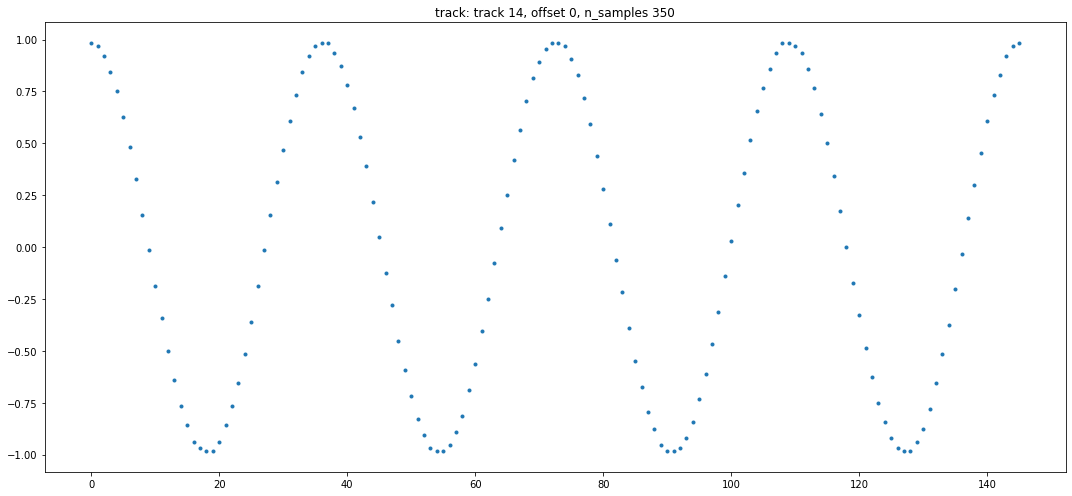

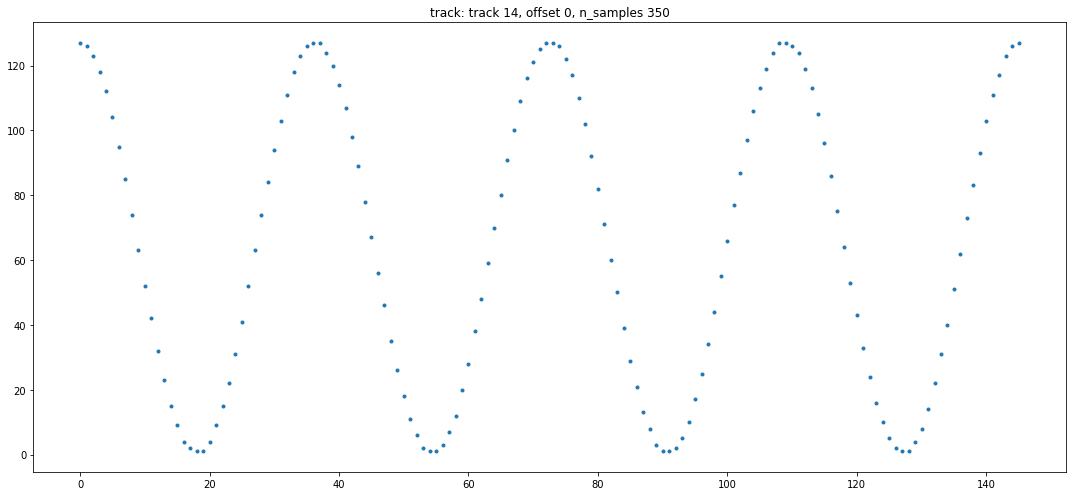

In [6]:
track_i = viz.plot_track(X, style='.')
viz.plot_track(Y, track_i, style='.')
track = X[track_i].numpy()
ipd.Audio(track, rate=p.sampling_rate)

In [7]:
utils.seed(p, use_deterministic_algorithms=False)
t.train()

  0%|          | 0/40 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/modules/module.py:785: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "
/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:39 loss 0.45699 lr 5.320725e-07: 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


# Results

Let's inspect what the model has learned by generating samples and laying them over each other.

In [8]:
def generate(m, ds, decoder, n_samples=256, batch_size = 10):
    track, *_ = sample.fast(m, ds.transforms, decoder, n_samples=n_samples, batch_size=batch_size)
    plt.figure(figsize=(15, 8))
    for i in range(batch_size):
        plt.plot(track.cpu()[i, 0, :])

## Argmax

The model has learned that sin is the most likely mode of the data. This is with starting values of 0. I'm not sure why this should be the case exactly, since I would expect starting values to be uniformly distributed between 0 and 120.

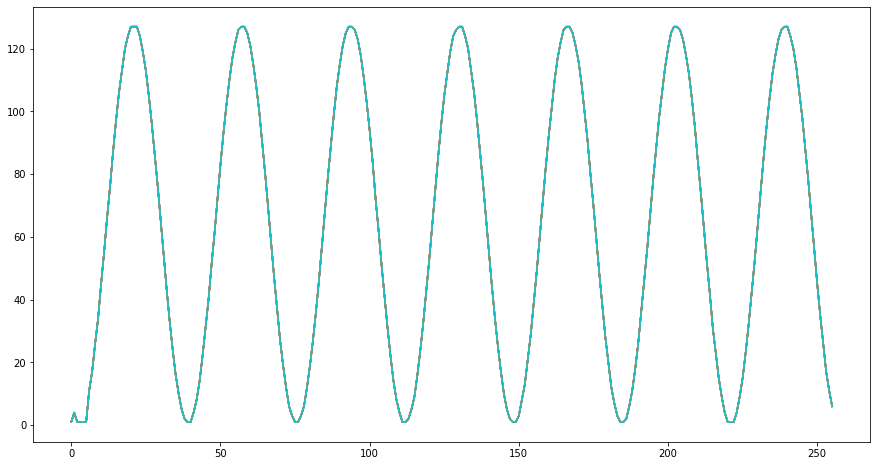

In [9]:
utils.seed(p, use_deterministic_algorithms=False)
generate(m, ds, utils.decode_argmax)

## Nucleus sampling with very likely values

Using nucleus sampling, we can relax the argmax a bit. Here we retain the top propbability mass. Now we've captured both `sin` and `cos`, respectively starting at the minimum and maximum values.

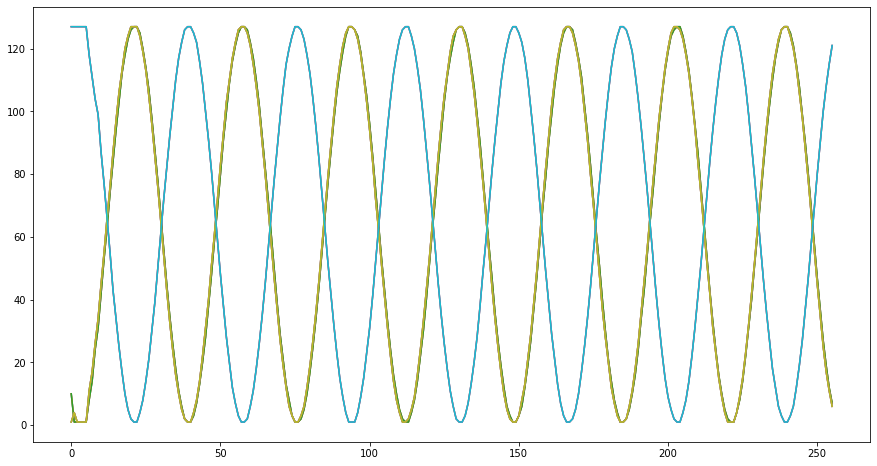

In [10]:
utils.seed(p, use_deterministic_algorithms=False)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))

## Nucleus sampling, relaxed a bit more

Now we've grabbed a further mode, which sometimes starts in the middle at 60 – the mean of `sin` and `cos`. There's more jitter overall.

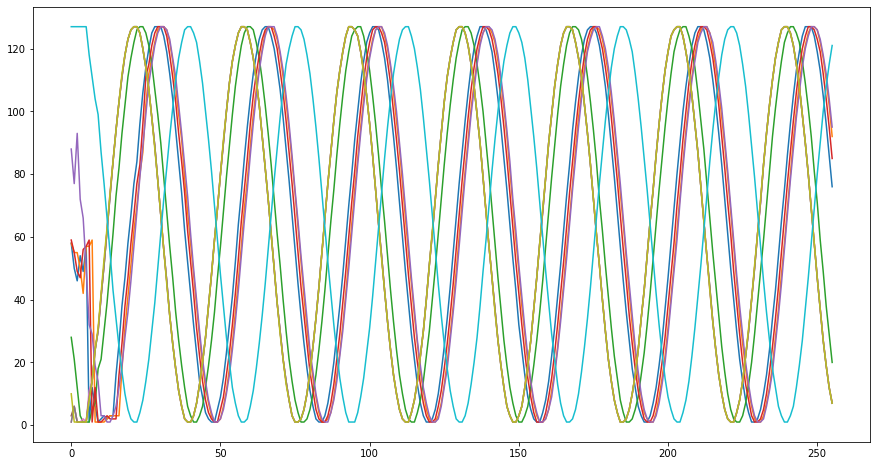

In [11]:
utils.seed(p, use_deterministic_algorithms=False)
generate(m, ds, utils.decode_nucleus(core_mass=0.4))

## Random

Now we're trying to reproduce the original distribution. Note that we still haven't got a very uniform reproduction.

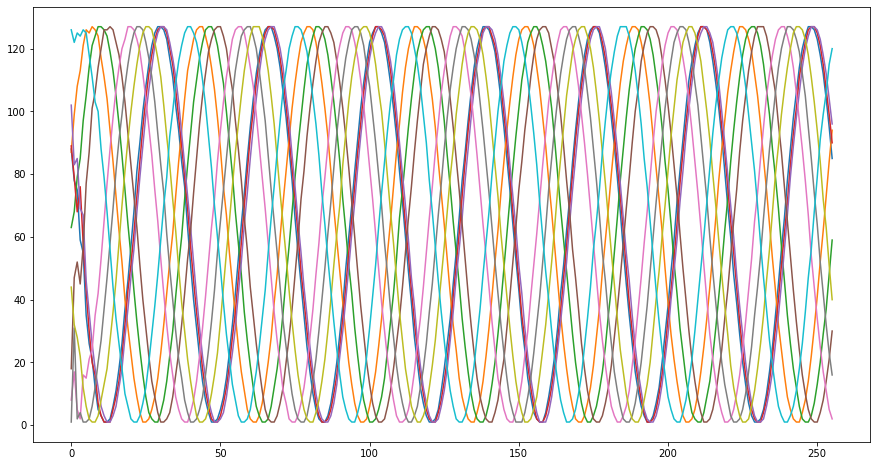

In [12]:
utils.seed(p, use_deterministic_algorithms=False)
generate(m, ds, utils.decode_random)